<a href="https://colab.research.google.com/github/lhmin0614/CS492_Coursework1/blob/main/Q1_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
%tensorflow_version 2.0x
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import time
from sklearn.neighbors import KNeighborsClassifier

drive.mount('/content/drive')
mat = loadmat('/content/drive/MyDrive/CS492_teamProject/face.mat')

X = mat['X']
y = mat['l'][0]

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0x`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
def plotImages(images_arr):
    arr_len = len(images_arr)
    fig, axes = plt.subplots(arr_len//5, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(ndimage.rotate(img, -90, reshape=True))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

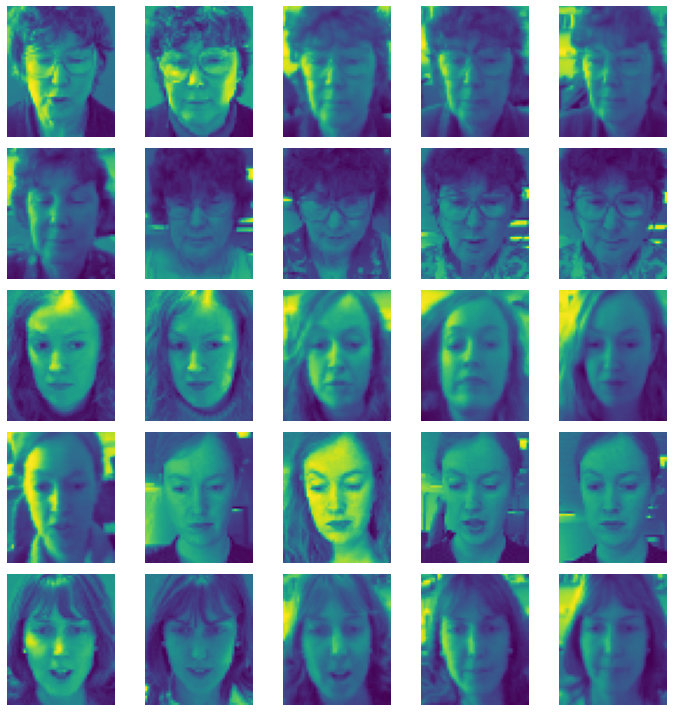

In [53]:
#visualize original images
X_visualize = [ vectors.reshape((46, 56))/255 for vectors in np.asarray(np.matrix(X).T)]
plotImages(X_visualize[:25])

In [54]:
#train/test split

train_X = [i[[True, True, True, True, False]*104] for i in X]      #split each sublist
test_X  = [i[[False, False, False, False, True]*104] for i in X]      #split each sublist
train_y = y[[True, True, True, True, False]*104]
test_y  = y[[False, False, False, False, True]*104]

print("<<Data dimension>>")
print("train_X : ", len(train_X)," * ", len(train_X[0]))
print("test_X  : ", len(test_X)," * ",  len(test_X[0]))
print("train_y : ", len(train_y))
print("test_y  : ", len(test_y))

<<Data dimension>>
train_X :  2576  *  416
test_X  :  2576  *  104
train_y :  416
test_y  :  104


<mean face>


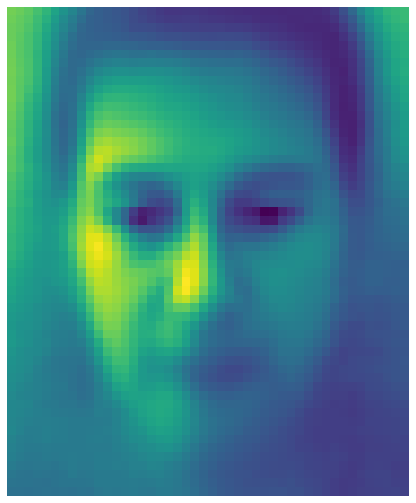

Training time: 3.9337105751037598s


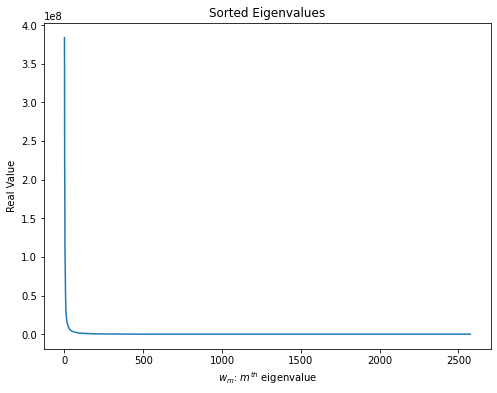

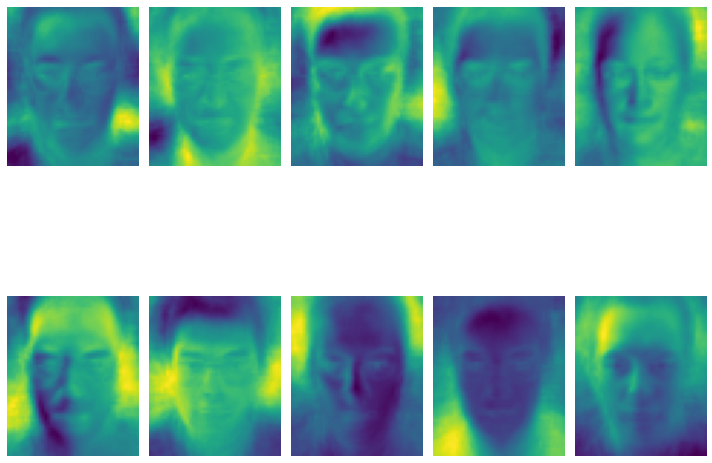

In [55]:
#PCA

avg_X = [ sum(i)/len(i) for i in train_X ]   #average value of each pixel
print("<mean face>")
plt.imshow(ndimage.rotate(np.asarray(avg_X).reshape(46, 56), -90, reshape=True))
plt.axis('off')
plt.show()

sub_X = [ list(np.asarray(x) - x_bar) for x, x_bar in zip(train_X, avg_X) ]
A = np.matrix(sub_X)
S = np.dot(A, A.T)#version1
#S = np.dot(A.T, A)#version 2  :  use low-dimension S

start = time.time()
eigvals, eigvecs_column = np.linalg.eigh(S)  
stop = time.time()
print(f"Training time: {stop - start}s")

#version2
#eigvecs_column = np.dot(A, eigvecs_column)

plt.figure(figsize=(8.0, 6.0))
plt.plot(range(len(eigvals)), eigvals[::-1])
plt.title('Sorted Eigenvalues')
plt.xlabel('$w_{m}$: $m^{th}$ eigenvalue')
plt.ylabel('Real Value')

#choose best eigenvectors (eigenface)
M=200
eigvecs = eigvecs_column.T
best_eigvals = eigvals[-M:]
best_eigvecs = eigvecs[-M:]

eigface = [np.asarray(vector).reshape((46, 56)) for vector in best_eigvecs]

plotImages(eigface[-10:])

#weighted sum
W = np.dot(A.T, np.matrix(best_eigvecs).T)

In [56]:
#kNN classifier with PCA-preprocessed data

def projection(X, avg_X, P) :
  A = np.matrix([ list(np.asarray(x) - x_bar) for x, x_bar in zip(X, avg_X) ])
  W = np.dot(A.T, P)
  return W

prj_X  = projection(train_X, avg_X, np.matrix(best_egvecs).T)
validation_X = projection(test_X, avg_X, np.matrix(best_eigvecs).T)

print("print accuracy train / test")

for i in range(7):
  classifier = KNeighborsClassifier(n_neighbors = i*2+1)
  classifier.fit(prj_X.tolist(), train_y)

  score_train = classifier.score(prj_X.tolist(), train_y)
  score_test = classifier.score(validation_X.tolist(), test_y)

  print("k="+str(i*2+1)+" : " +str(score_train) + "/" + str(score_test))

print accuracy train / test
k=1 : 1.0/0.75
k=3 : 0.7139423076923077/0.6057692307692307
k=5 : 0.6322115384615384/0.5096153846153846
k=7 : 0.5528846153846154/0.47115384615384615
k=9 : 0.4951923076923077/0.4519230769230769
k=11 : 0.46153846153846156/0.4326923076923077
k=13 : 0.4519230769230769/0.41346153846153844


(416, 2576)
average reconstruct error when M : 200 is 1590.4910216567612


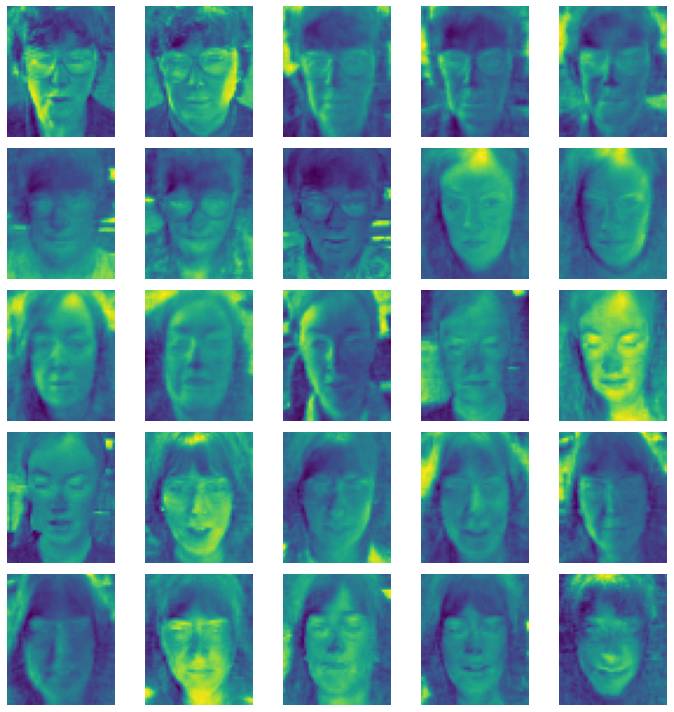

In [76]:
#reconstruction
X_weighted_sum = np.dot(W, np.matrix(best_eigvecs))
print(X_weighted_sum.shape)

X_reconst = [list(np.asarray(x) + x_bar) for x, x_bar in zip(X_weighted_sum.tolist(), avg_X) ]

reconst_err = [np.linalg.norm(i-j) for i, j in zip(X_reconst, np.asarray(np.matrix(train_X).T))]
reconst_err_avg = sum(reconst_err)/len(reconst_err)
print("average reconstruct error when M : "+ str(M)+" is " + str(reconst_err_avg))

X_reconst_vis = [np.asarray(vector).reshape((46, 56)) for vector in X_reconst]

plotImages(X_reconst_vis[:25])

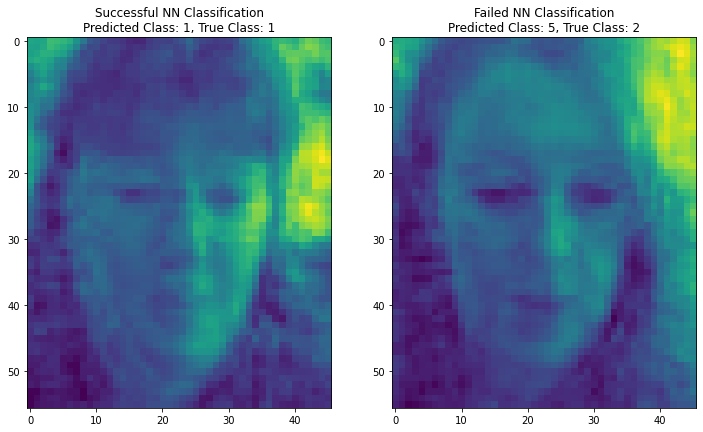

In [81]:
#example true/false prediction
classifier = KNeighborsClassifier(n_neighbors = 1)
classifier.fit(prj_X.tolist(), train_y)

validation_X = projection(test_X, avg_X, np.matrix(best_eigvecs).T,)
preds_y=classifier.predict(validation_X)

done = {'success': False, 'failure': False}
plt.rcParams['figure.figsize'] = [12.0, 9.0]
fig, axes = plt.subplots(ncols=2)

for y, t, x_ in zip(preds_y, test_y, np.array(np.matrix(test_X).T)):
    if y == t and done['success'] is False:
        X_projection = np.dot((x_-avg_X), np.matrix(best_eigvecs).T)
        X_weighted_sum = np.dot(X_projection, np.matrix(best_eigvecs))
        x_hat = avg_X + np.dot(X_projection, np.matrix(best_eigvecs))
        axes[0].imshow(x_hat.reshape(46,56).T)
        axes[0].set_title(
            'Successful NN Classification\nPredicted Class: %d, True Class: %d' % (y, t))
        done['success'] = True
    elif y != t and done['failure'] is False:
        X_projection = np.dot((x_-avg_X), np.matrix(best_eigvecs).T)
        X_weighted_sum = np.dot(X_projection, np.matrix(best_eigvecs))
        x_hat = avg_X + np.dot(X_projection, np.matrix(best_eigvecs))
        axes[1].imshow(x_hat.reshape(46,56).T)
        axes[1].set_title(
            'Failed NN Classification\nPredicted Class: %d, True Class: %d' % (y, t))
        done['failure'] = True